In [1]:
#!python -m spacy download en_core_web_md

In [2]:
#!pip install flair

In [3]:
#!pip install pyspellchecker

In [4]:
#!pip install --upgrade setuptools wheel

In [5]:
#!pip install top2vec

In [6]:
#!pip install top2vec[sentence_encoders]

In [445]:
import pandas as pd
from bs4 import BeautifulSoup
import glob
import os
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import spacy
import contractions
import nltk
import re
from nltk import bigrams, trigrams, word_tokenize
from collections import Counter
import swifter
import itertools
from flair.models import SequenceTagger
from flair.data import Sentence
import numpy as np
import random
from spellchecker import SpellChecker
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import chardet
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models import Word2Vec
import seaborn as sns
from sklearn.metrics.pairwise import cosine_distances
from top2vec import Top2Vec
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin


In [385]:
# Get all the html file names
html_files = glob.glob('*.html')

In [386]:
print(f'Number of html_files in the current directory: {len(html_files)}')

Number of html_files in the current directory: 1458


In [387]:
jobs_data = {}

In [388]:
encoding_scheme = {}

In [389]:
# Finding the encoding for each of the html file.
for html_file in html_files:
    
    # Open the file in binary mode
    with open(html_file, 'rb') as f:
        data = f.read()

    # Detect the encoding
    result = chardet.detect(data)
    encoding = result['encoding']

    # Decode the HTML file using the found encoding.
    decoded_html = data.decode(encoding)
    
    # Store the encoding scheme for each html file
    encoding_scheme[html_file] = encoding

In [390]:
# After analyzing the html files, many of the job postings have the job requirements and skill
# sets enclosed with li tags. Some of them do not have job requirements listed under li tags
# but under different parent tag. Some of them(138 files) do not have li tags at all in 
# their html body.

In [391]:
for html_file in html_files:
    # Open and read the html file
    with open(html_file, 'rb') as file:
        data = file.read()
    
    # Get html content
    content = data.decode(encoding_scheme[html_file])

    # Parse the data using BeautifulSoup html parser
    soup = BeautifulSoup(content, 'html.parser')
    
    # Extract the job titles    
    job_title = soup.title.string

    # Get html body text.
    body_text = soup.body.text

    # Extract all li tags from the html file and merge them together.
    li_tags = soup.find_all('li')
    if li_tags:
        li_texts = ' '.join([tag.text + '.' for tag in li_tags])  
        # If the length of the li text is less than 500 characters, then we consider 
        # entire body text for further analysis
        if len(li_texts) >= 500:
            # Save job title and li texts for each html file
            jobs_data[html_file] = [job_title, li_texts]
        else:
            # Save job title and body texts for each html file
            jobs_data[html_file] = [job_title, body_text]            
    else:
        # Save job title and body texts for each html file
        jobs_data[html_file] = [job_title, body_text]

In [392]:
# Create a dataframe named job_postings from the required parsed data
job_postings = pd.DataFrame.from_dict(jobs_data, orient='index', columns=['job_title', 'job_desc'])

In [393]:
job_postings.reset_index(inplace=True)

In [394]:
job_postings.head()

index                                          job_title  \
0  001b92395ed0fb62.html                   Data Scientist - Beavercreek, OH   
1  00321a48d04fe754.html                 Data Scientist - Seattle, WA 98101   
2  0079c11b2611349f.html                        Data Scientist - Newark, CA   
3  007d9d7b5c09d820.html  Patient Care Assistant / PCA - Med/Surg (Fayet...   
4  00bf37ae19c7dfd7.html               Data Manager / Analyst - Oakland, CA   

                                            job_desc  
0  Use statistical research methods to analyze da...  
1  Interface with our internal engagement teams a...  
2   Design, develop, document and maintain machin...  
3  Provides all personal care services in accorda...  
4  You possess excellent communication and relati...

In [395]:
job_postings.rename(columns={'index': 'file_name'}, inplace=True)

In [396]:
print(f'Are there any duplicate rows: {len(job_postings[job_postings.duplicated()])}')

Are there any duplicate rows: 0


In [397]:
job_postings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  1458 non-null   object
 1   job_title  1458 non-null   object
 2   job_desc   1458 non-null   object
dtypes: object(3)
memory usage: 34.3+ KB


In [398]:
# Remove leading and trailing spaces 
job_postings['job_desc'] = job_postings['job_desc'].apply(lambda x: x.strip())

In [399]:
# Checking for any records with empty job description
empty_rows = job_postings[job_postings['job_desc'] == '']

In [400]:
empty_rows.shape

(0, 3)

In [401]:
job_postings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  1458 non-null   object
 1   job_title  1458 non-null   object
 2   job_desc   1458 non-null   object
dtypes: object(3)
memory usage: 34.3+ KB


In [402]:
# Finding the total words in the corpus
total_words = job_postings['job_desc'].str.split().apply(len).sum()
print(f'Total number of words in the corpus before cleaning up: [{total_words}]')

Total number of words in the corpus before cleaning up: [482310]


In [403]:
# Load spacy model for named entity recognition
nlp = spacy.load('en_core_web_md')

In [404]:
# NLTK stop word list.
stop_words = set(stopwords.words('english'))
print(f'Number of stop words in English: {len(stop_words)}')

Number of stop words in English: 179


In [405]:
job_postings['job_title']

0                        Data Scientist - Beavercreek, OH
1                      Data Scientist - Seattle, WA 98101
2                             Data Scientist - Newark, CA
3       Patient Care Assistant / PCA - Med/Surg (Fayet...
4                    Data Manager / Analyst - Oakland, CA
                              ...                        
1453                      Data Scientist - Glen Mills, PA
1454                Data Analyst (Part-Time) - Austin, TX
1455    Manager - Business Development (Central and Ea...
1456    Natural Language Processing Undergraduate Inte...
1457       Political Staffer - San Francisco Bay Area, CA
Name: job_title, Length: 1458, dtype: object

In [406]:
# Splitting the job_title column into title and location
split_data = job_postings['job_title'].str.rsplit('-', n=1, expand=True)
job_postings['title'] = split_data[0]
#job_postings['location'] = split_data[1]

In [407]:
job_postings.drop('job_title', axis=1, inplace=True)

In [408]:
job_postings.rename(columns={'title': 'job_title'}, inplace=True)

In [409]:
job_postings.head()

file_name                                           job_desc  \
0  001b92395ed0fb62.html  Use statistical research methods to analyze da...   
1  00321a48d04fe754.html  Interface with our internal engagement teams a...   
2  0079c11b2611349f.html  Design, develop, document and maintain machine...   
3  007d9d7b5c09d820.html  Provides all personal care services in accorda...   
4  00bf37ae19c7dfd7.html  You possess excellent communication and relati...   

                                           job_title  
0                                    Data Scientist   
1                                    Data Scientist   
2                                    Data Scientist   
3  Patient Care Assistant / PCA - Med/Surg (Fayet...  
4                            Data Manager / Analyst

#### Pre-processing of job_title column

In [410]:
# Replace all special characters with space
job_postings['job_title'] = job_postings['job_title'].apply(
    lambda x: re.sub(r'[^a-zA-Z0-9\s]', ' ', x))

# Replace words with digits with space 
job_postings['job_title'] = job_postings['job_title'].apply(
    lambda x: re.sub(r'\b\w*\d\w*\b', ' ', x))

# Replace multiple spaces with single space
job_postings['job_title'] = job_postings['job_title'].apply(
    lambda x: re.sub(r'\s+', ' ', x))

# Convert string to lower
job_postings['job_title'] = job_postings['job_title'].str.lower()

# Replace multiple spaces with single space
job_postings['job_title'] = job_postings['job_title'].apply(
    lambda x: x.strip())


In [411]:
job_postings.sample(5)

file_name  \
737   7ad5e9409deb84c5.html   
1436  fb2912f036afd8c6.html   
740   7b5cbb5b54a2aa2d.html   
706   74d64b882f79a0bd.html   
632   68b9253167629155.html   

                                               job_desc  \
737   You will work with large data sets and derive ...   
1436  Understanding business objectives and developi...   
740   Selecting features, building and optimizing cl...   
706   DIE CUTTER ASSISTANT - New Oxford, PA 17350\nP...   
632   Idea Generation: Analyzing both our B2B and B2...   

                                              job_title  
737   intern telco and edge cloud wireless network t...  
1436                                     data scientist  
740                                      data scientist  
706                                die cutter assistant  
632                                     product analyst

In [412]:
# Tokenized text for training the word2vec model
tokenized_text = job_postings['job_title'].str.split()

In [413]:
# Train the Word2Vec model
model = Word2Vec(tokenized_text, vector_size=500, window=3, 
                 min_count=2, workers=4, sg=0)

In [414]:
# Get the vector representation of the given job title.
def get_job_title_vector(title, model):
    # Remove any words not in the model's vocabulary
    words = [word.lower() for word in title.split() if word.lower() in model.wv.key_to_index]

    # None of the words in the title found in the vocabulary
    if len(words) == 0:
        return np.zeros(model.vector_size)

    # Return the mean of the embeddings of the words in the title
    return np.mean([model.wv[word] for word in words], axis=0)

In [415]:
# Predefined job title relevant to the data science domain
predef_titles = ['data scientist',
                 'data analyst',
                 'big data engineer',
                 'machine learning engineer',
                 'natural language processing engineer',
                 'machine learning specialist',
                 'product analyst',
                 'deep learning specialist',
                 'statistician',
                 'ai engineer',
                 'data visualization specialist',
                 'data mining specialist',
                 'data science research intern',
                 'modeling analyst',
                 'ai research',
                 'bio statistician',
                 'bio informatician',
                 'computational biologist'
                ]

In [416]:
# Get the vector representations of all the job titles
job_title_vectors = np.array(
    [get_job_title_vector(job_title, model) for job_title in job_postings['job_title']])

# Get the vector representations of predefined job titles
predef_title_vectors = np.array(
    [get_job_title_vector(job_title, model) for job_title in predef_titles])

In [417]:
# Creating similarity dataframe
similarity_df = pd.DataFrame(columns=predef_titles)

In [418]:
threshold = 0.55
non_ds_job_indices = []

for i, job_title_vec in enumerate(job_title_vectors):
    # cosine_distances : measures dissimilarity between the vectors
    dissimilarity_scores = [cosine_distances(job_title_vec.reshape(1, -1), 
                                          predef_title_vec.reshape(1, -1))[0][0] for predef_title_vec in predef_title_vectors]
    
    # Get the minimum dissimilarity score
    min_val = min(dissimilarity_scores)

    # If the given job title is more dissimilar(greater than threshold) with 
    # all of the predefined titles, then we can consider the given job title is not related
    # to Data Science domain
    if min_val > threshold:
        non_ds_job_indices.append(i)

    # Store the dissimilarity scores in the dataframe
    similarity_df.loc[len(similarity_df)] = dissimilarity_scores

print(len(non_ds_job_indices))

40


In [419]:
non_ds_job_indices

[43,
 84,
 110,
 127,
 129,
 182,
 202,
 229,
 268,
 283,
 306,
 309,
 348,
 404,
 416,
 419,
 428,
 461,
 467,
 489,
 499,
 571,
 619,
 716,
 782,
 797,
 838,
 861,
 895,
 948,
 1166,
 1170,
 1204,
 1248,
 1321,
 1348,
 1366,
 1387,
 1397,
 1457]

In [420]:
job_postings.iloc[non_ds_job_indices].sample(5)

file_name                                           job_desc  \
499  511353d381dde347.html  Working knowledge of:. The principles, practic...   
127  170203f4c2b41286.html  Minimum three years of experience designing an...   
110  14a59bf4f1f9e350.html  Recruits and screens applicants. Maintains emp...   
716  77da4e07dda1d1d0.html  Over 5.5 years of experience as python Full St...   
416  43b5749675ce235b.html  Be on the forefront of a growing business!. Co...   

                          job_title  
499    veterans certifying official  
127                    cartographer  
110              hr controller dual  
716          talend automation spoc  
416  field scout wonderful orchards

In [421]:
similarity_df.loc[3]

data scientist                          0.034472
data analyst                            0.037119
big data engineer                       0.040221
machine learning engineer               0.046061
natural language processing engineer    0.034796
machine learning specialist             0.052665
product analyst                         0.076105
deep learning specialist                0.062679
statistician                            0.628721
ai engineer                             0.044463
data visualization specialist           0.048864
data mining specialist                  0.040853
data science research intern            0.030622
modeling analyst                        0.065039
ai research                             0.055211
bio statistician                        0.237197
bio informatician                       0.224659
computational biologist                 0.192973
Name: 3, dtype: float64

In [422]:
job_postings.loc[3].job_desc

'Provides all personal care services in accordance with the plan of treatment assigned by the registered nurse. Accurately documents care provided. Applies safety principles and proper body mechanics to the performance of specific techniques of personal and supportive care, such as ambulation of patients, transferring patients, assisting with normal range of motions and positioning. Participates in economical utilization of supplies and ensures that equipment and nursing units are maintained in a clean, safe manner. Routinely follows and adheres to all policies and procedures. Assists in performance improvement (PI) activities by serving on PI teams as warranted, assisting with PI measures and supporting and implementing changes necessary for improvement. Maintains performance, patient and employee satisfaction and financial standards as outlined in the performance evaluation. Performs compliance requirements as outlined in the Employee Handbook. Must adhere to the DCH Behavioral Stand

In [423]:
# Remove the non-ds job indices from the df
job_postings = job_postings.drop(non_ds_job_indices)

# Reset the index
job_postings = job_postings.reset_index(drop=True)

In [424]:
job_postings.shape

(1418, 3)

In [425]:
job_postings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1418 entries, 0 to 1417
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  1418 non-null   object
 1   job_desc   1418 non-null   object
 2   job_title  1418 non-null   object
dtypes: object(3)
memory usage: 33.4+ KB


In [426]:
# Since we are done with filtering irrelevant job titles, we can drop that column
#job_postings.drop('job_title', axis=1, inplace=True)

In [427]:
job_postings.head()

file_name                                           job_desc  \
0  001b92395ed0fb62.html  Use statistical research methods to analyze da...   
1  00321a48d04fe754.html  Interface with our internal engagement teams a...   
2  0079c11b2611349f.html  Design, develop, document and maintain machine...   
3  007d9d7b5c09d820.html  Provides all personal care services in accorda...   
4  00bf37ae19c7dfd7.html  You possess excellent communication and relati...   

                                        job_title  
0                                  data scientist  
1                                  data scientist  
2                                  data scientist  
3  patient care assistant pca med surg fayette al  
4                            data manager analyst

### Text preprocessing

In [428]:
# Replace consecutive newlines with a space
def remove_newlines(text):
    text = re.sub(r'\n+', ' ', text)
    return text

In [429]:
# Replace consecutive periods with a single period
def remove_multiple_periods(text):
    text = re.sub(r'\.+', '.', text)
    return text

In [430]:
job_postings['job_desc'] = job_postings['job_desc']\
                                .swifter.apply(lambda x: remove_newlines(x))
job_postings['job_desc'] = job_postings['job_desc']\
                                .swifter.apply(lambda x: remove_multiple_periods(x))

Pandas Apply:   0%|          | 0/1418 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1418 [00:00<?, ?it/s]

In [431]:
# Remove HTTP and WWW URLs with a space
def remove_urls(text):
    text = re.sub(r'(https?://\S+)|(\bwww\.\S+\b)', ' ', text)
    return text

In [432]:
job_postings['job_desc'] = job_postings['job_desc']\
                                .swifter.apply(lambda x: remove_urls(x))

Pandas Apply:   0%|          | 0/1418 [00:00<?, ?it/s]

In [433]:
# Replace consecutive spaces with single space.
def remove_multiple_spaces(text):
    text = re.sub(r'\s+', ' ', text)
    return text

By analyzing the job title, we see that most of the requirements are from the United States Of America. The job location details in the text can be removed as this is not gonna helpful in finding the skilled keywords.

In [434]:
us_state_abbreviations = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

In [435]:
state_names = list(us_state_abbreviations.keys())
state_abbr = list(us_state_abbreviations.values())

In [436]:
state_names = [word.lower() for word in state_names]
state_abbr = [word.lower() for word in state_abbr]

In [437]:
def remove_location_details(text):
    words = text.split()
    
    filtered_words = []
    for word in words:
        if (word in state_names) or (word in state_abbr):
            continue
        else:
            filtered_words.append(word)
            
    return ' '.join(filtered_words)

In [438]:
ethnicity_options = [
    'White',
    'non-Hispanic',
    'Black',
    'African American',
    'Hispanic',
    'Latino',
    'Asian',
    'Native American', 
    'Alaska Native',
    'Native Hawaiian',
    'Other Pacific Islander',
]
ethnicity_options = [word.lower() for word in ethnicity_options]
ethnicity_options

['white',
 'non-hispanic',
 'black',
 'african american',
 'hispanic',
 'latino',
 'asian',
 'native american',
 'alaska native',
 'native hawaiian',
 'other pacific islander']

In [439]:
def remove_ethnicity_details(text):
    words = text.split()
    
    filtered_words = []
    for word in words:
        if word in ethnicity_options:
            continue
        else:
            filtered_words.append(word)

    return ' '.join(filtered_words)

In [440]:
job_postings.head()

file_name                                           job_desc  \
0  001b92395ed0fb62.html  Use statistical research methods to analyze da...   
1  00321a48d04fe754.html  Interface with our internal engagement teams a...   
2  0079c11b2611349f.html  Design, develop, document and maintain machine...   
3  007d9d7b5c09d820.html  Provides all personal care services in accorda...   
4  00bf37ae19c7dfd7.html  You possess excellent communication and relati...   

                                        job_title  
0                                  data scientist  
1                                  data scientist  
2                                  data scientist  
3  patient care assistant pca med surg fayette al  
4                            data manager analyst

In [441]:
spell_corrections_dict = {
    'slq': 'sql'
}

In [442]:
def auto_spell_correct(text):
    for key, val in spell_corrections_dict.items():
        pattern = r'\b{}\b'.format(re.escape(key))
        text = re.sub(pattern, val, text)
    return text

In [446]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, stop_words=None):
        self.stop_words = stop_words

    def fit(self, X, y=None):
        # There is no learning from the training data 
        return self

    def transform(self, X, y=None):
        return X.apply(self.preprocess_text)

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X, y)
    
    def preprocess_text(self, text):
        # Convert text to lowercase.
        text = text.lower()

        # Remove location and ethnicity info
        text = remove_location_details(text)

        # Remove ethnicity details
        text = remove_ethnicity_details(text)

        # Expand contractions
        text = contractions.fix(text)

        # Lemmatize text
        doc = nlp(text)
        text = " ".join([token.lemma_ for token in doc])

        # Remove configured stop words
        text = " ".join([word for word in text.split() if word not in stop_words])

        # Remove special characters
        text = re.sub(r'[^a-zA-Z0-9\s\+\+]', ' ', text)

        # Remove the words with only special characters
        text = " ".join([word for word in text.split() if word.isalnum()])

        # Remove the words with only digits
        text = " ".join([word for word in text.split() if not word.isdigit()])

        # Remove the words with only special characters
        text = " ".join([word for word in text.split() if word.isalnum()])

        # Remove the words with only s
        text = " ".join([word for word in text.split() if word != 's'])

        # Auto spell correct: This is specific to the corpus
        text = auto_spell_correct(text)

        # Replace multiple spaces with a single space
        text = re.sub(r'\s+', ' ', text)

        # Remove leading and trailing spaces if any
        text = text.strip()

        return text

In [449]:
pre_processor = TextPreprocessor(stop_words=stop_words)

In [450]:
job_postings['pre_processed'] = pre_processor.fit_transform(job_postings['job_desc'])

In [451]:
job_postings.sample(5)

file_name  \
752   818c448500b71a0b.html   
747   81505152254a98f8.html   
427   49f85c468f4849f5.html   
314   34cb6265a33472c7.html   
1308  e9819b1e053ec480.html   

                                               job_desc  \
752   Develop Individualized Program (IP) for each m...   
747   Work with various teams to understand Facebook...   
427   Lead and perform hands-on analysis and modelin...   
314   Increase expertise amongst Pfizer statistician...   
1308  Earned or have the ability to earn a bachelor’...   

                                           job_title  \
752   certified strength and conditioning specialist   
747       network modeling and optimization engineer   
427                                   data scientist   
314      statistician biomarkers genomics sr manager   
1308                                   jr consultant   

                                          pre_processed  
752   develop individualized program ip member serve...  
747   work various team understand facebook network ...  
427   lead perform hand analysis modeling involve cr...  
314   increase expertise amongst pfizer statistician...  
1308  earn ability earn bachelor computer science en...

In [452]:
# Finding the total words in the corpus
total_words = job_postings['pre_processed'].str.split().apply(len).sum()
print(f'Total number of words in the corpus after cleaning up: [{total_words}]')

Total number of words in the corpus after cleaning up: [334510]


### Analysis of word frequency

In [453]:
preprocessed_words = job_postings['pre_processed'].str.split().sum()

In [454]:
def gen_word_freq_plot(words):
    print(f'Number of words in this corpus : {len(words)}')  
    word_freq = Counter(words)
    
    # Top 20 most frequent words in this corpus
    n = 20
    top_n = word_freq.most_common(n)
    words, frequencies = zip(*top_n)  

    # Plot the word frequencies
    fig, ax = plt.subplots(figsize=(6, 3))
    plt.xticks(rotation='vertical')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(f'Frequently used words in the corpus')
    sns.barplot(x=list(words), y=list(frequencies), ax=ax) 
    plt.show()

Number of words in this corpus : 334510


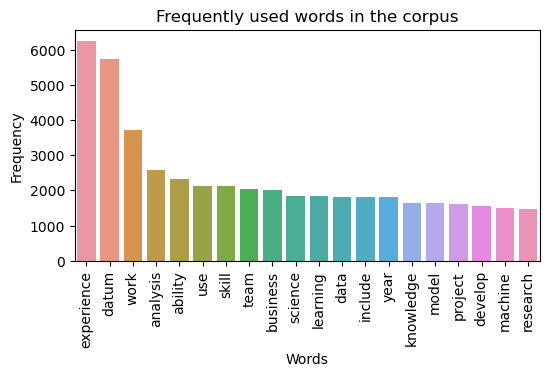

In [455]:
gen_word_freq_plot(preprocessed_words)

### Word Cloud

In [456]:
def gen_word_cloud(words):   
    corpus_text = ' '.join(words)

    # Generate word cloud from the corpus
    wordcloud = WordCloud(width=800, 
                          height=400, 
                          background_color='black', 
                         ).generate(corpus_text)

    # Create the plot
    plt.figure(figsize=(7, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud in the corpus')
    plt.axis('off')
    plt.show()

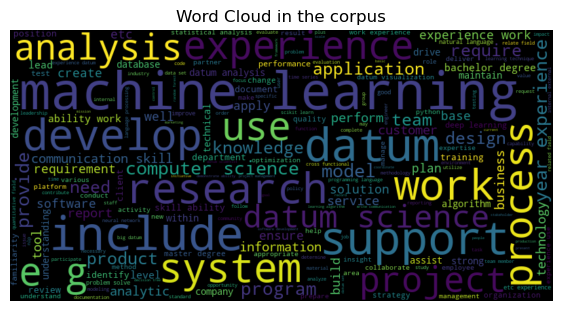

In [457]:
gen_word_cloud(preprocessed_words)

### Analysis of length of the job postings

In [458]:
def gen_len_plot(job_postings_len):

    print(f'Minimum length of the job postings in this corpus: {job_postings_len.min()}')
    print(f'Maximum length of the job postings in this corpus: {job_postings_len.max()}')    
    # Create a figure and axes with desired figsize
    fig, ax = plt.subplots(figsize=(4, 3))

    plt.xlabel('Length')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of length of the job postings in this corpus')

    sns.histplot(job_postings_len, kde=True, ax=ax)    

In [459]:
def gen_word_count_plot(word_count):

    print(f'Minimum word count of the job postings in this corpus: {word_count.min()}')
    print(f'Maximum word count of the job postings in this corpus: {word_count.max()}')   

    # Create a figure and axes with desired figsize
    fig, ax = plt.subplots(figsize=(4, 3))

    plt.xlabel('Word Count')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of word count of the job postings in this corpus')

    sns.histplot(word_count, kde=True, ax=ax)    

In [460]:
# Calculate text lengths
job_postings['pre_processed_text_len'] = job_postings['pre_processed'].str.len()

In [461]:
# Calculate word count
job_postings['pre_processed_word_count'] = job_postings['pre_processed'].apply(
    lambda x: len(x.split()))

Minimum length of the job postings in this corpus: 45
Maximum length of the job postings in this corpus: 18187


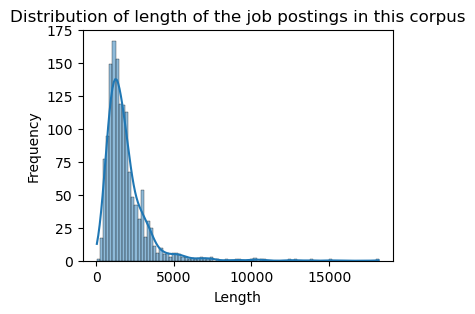

In [462]:
gen_len_plot(job_postings['pre_processed_text_len'])

Minimum word count of the job postings in this corpus: 5
Maximum word count of the job postings in this corpus: 2259


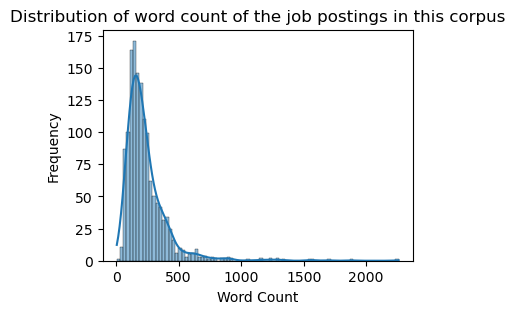

In [463]:
gen_word_count_plot(job_postings['pre_processed_word_count'])

In [464]:
job_postings[job_postings['pre_processed_word_count'] == 5]

file_name                                           job_desc  \
35  07c5ef8930178c96.html  Director of Econometric Modeling - External Ca...   

                           job_title  \
35  director of econometric modeling   

                                    pre_processed  pre_processed_text_len  \
35  director econometric modeling external career                      45   

    pre_processed_word_count  
35                         5

In [276]:
job_postings.loc[35].job_desc

'Director of Econometric Modeling - External Careers'

In [472]:
job_postings[job_postings['pre_processed_word_count'] >= 1000].head()

file_name                                           job_desc  \
44   09b405a07dc2ebcf.html  You will analyze organization, layout and cont...   
162  1cb77bad57881319.html  Participates as a team member with the scienti...   
196  21fd63ec0bf10a9c.html  Data Science Analyst - Chicago, IL 60612 Job T...   
199  223edfed33bd3840.html  Liaises with the National Security Council, U....   
511  56a6f4598dd4f43f.html  You will serve as the System Development Activ...   

                                         job_title  \
44   technical information specialist web services   
162              biological science lab technician   
196                           data science analyst   
199                        foreign affairs officer   
511                             engineer scientist   

                                         pre_processed  \
44   analyze organization layout content utilize us...   
162  participate team member scientist phase resear...   
196  data science analyst chicago job title datum s...   
199  liaise national security council you agency in...   
511  serve system development activity sda test lea...   

     pre_processed_text_len  pre_processed_word_count  
44                     9131                      1156  
162                   12801                      1569  
196                    9064                      1163  
199                   10163                      1241  
511                   13761                      1700

In [467]:
job_postings.loc[685].job_desc

"Machine Learning Specialist Senior / Intermediate - Ann Arbor, MI 48109 Job Opening ID: 178584 Work Location: Ann Arbor Campus Full Time/Part Time: Full-Time Regular/Temporary: Regular FLSA Status: Exempt Organizational Group: Its Institutional Department: ITS Adv Research Comp Tech Srv Posting Begin/End Date: 9/25/2019 - 11/09/2019 Salary: $68,462.00 - $105,000.00 Paid Time Off: Career Interest: Information Technology How to Apply To be considered, a cover letter and resume are required. The cover letter must be the leading page of your resume and should: Specifically outline the reasons for your interest in the position and Outline your particular skills and experience that directly relate to this position. Starting salaries will vary depending upon the qualifications and experience of the selected candidate. Underfill Statement This position will be filled at the Senior salary range of $80,769 - $105,000 as the primary goal. The requirements listed below reflect the Senior level ex

In [475]:
job_postings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1418 entries, 0 to 1417
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   file_name                 1418 non-null   object
 1   job_desc                  1418 non-null   object
 2   job_title                 1418 non-null   object
 3   pre_processed             1418 non-null   object
 4   pre_processed_text_len    1418 non-null   int64 
 5   pre_processed_word_count  1418 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 66.6+ KB


### Unsupervised Learning

### Clustering Method 1: Word2Vec, PCA and K-Means

In [485]:
# Get the vector representation of the given job description.
def get_job_desc_vector(desc, model):
    # Remove any words not in the model's vocabulary
    words = [word.lower() for word in desc.split() if word.lower() in model.wv.key_to_index]

    # None of the words in the title found in the vocabulary
    if len(words) == 0:
        return np.zeros(model.vector_size)

    # Return the mean of the embeddings of the words in the desc
    return np.mean([model.wv[word] for word in words], axis=0)

In [487]:
# Train the Word2Vec model
word2vec_model = Word2Vec(sentences = job_postings['pre_processed'].str.split(), 
                          vector_size=2000, 
                          window=7, 
                          min_count=6, 
                          workers=4, 
                          sg=0)

In [488]:
# Get the vector representations of all the job descriptions
job_desc_vectors = np.array(
    [get_job_desc_vector(job_desc, word2vec_model) for job_desc in job_postings['pre_processed']])

In [489]:
max_value = 10
components = range(1, max_value+1, 2)

exp_var = []

# Find the optimal number of components for dimensionality reduction.
for comp in components:
    pca = PCA(n_components=comp)
    pca.fit(job_desc_vectors)
    var_exp = pca.explained_variance_ratio_.sum()
    exp_var.append(var_exp)

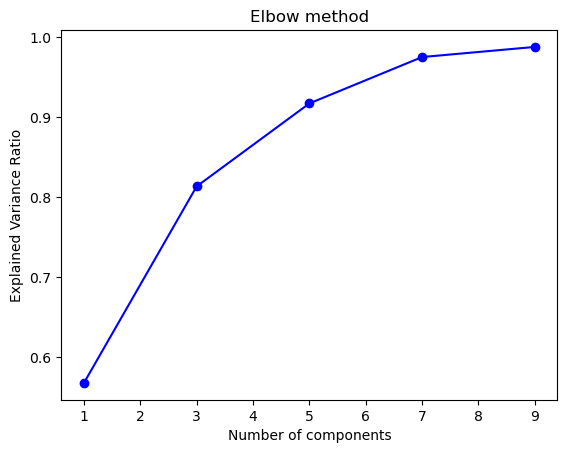

In [490]:
plt.plot(components, exp_var, 'bo-')
plt.xlabel('Number of components')
plt.ylabel('Explained Variance Ratio')
plt.title('Elbow method')
plt.show()

In [491]:
exp_var

[0.56793004, 0.81350726, 0.91715956, 0.9750915, 0.98772824]

In [492]:
# Perform PCA
num_components = 5 # around 92% varaiance is explained
pca = PCA(n_components=num_components)
result = pca.fit_transform(job_desc_vectors)

In [493]:
sil = []
for k in range(2, 20, 5):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(result)
    preds = kmeans.predict(result)
    sil.append(silhouette_score(result, preds, metric = 'cosine'))

C:\Users\subbu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\subbu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\subbu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\subbu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

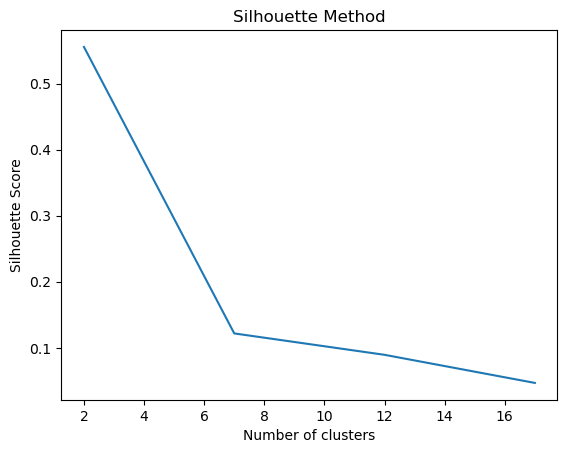

In [494]:
plt.plot(range(2, 20, 5), sil)
plt.title('Silhouette Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [501]:
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(result)
labels = kmeans.predict(result)

C:\Users\subbu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


In [502]:
# Additional code to generate word clouds
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()



Cluster: 0


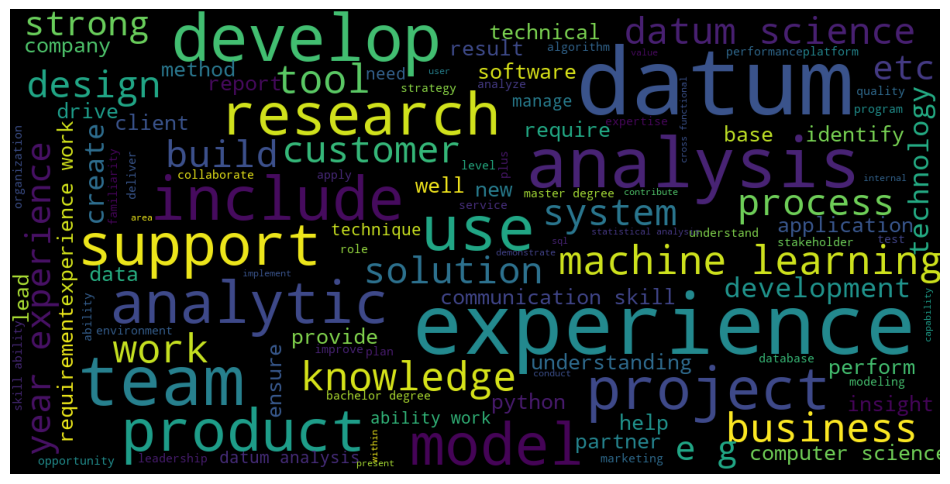


Cluster: 1


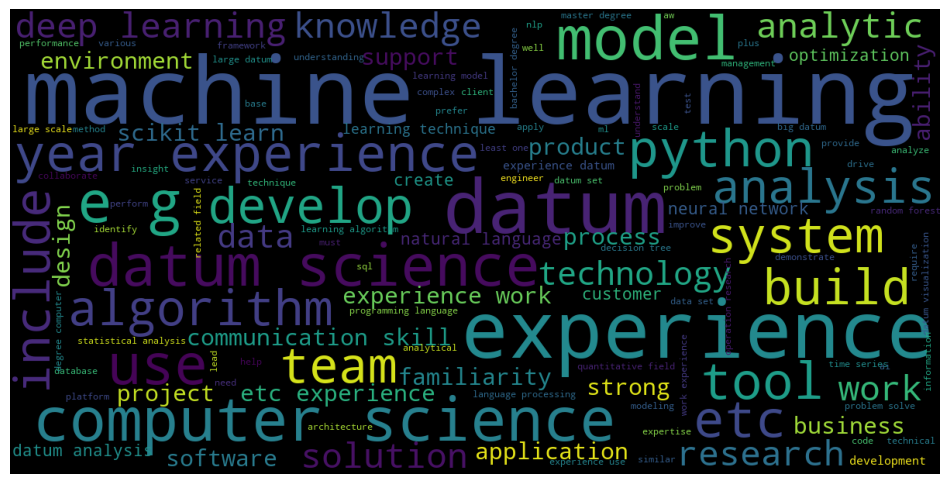


Cluster: 2


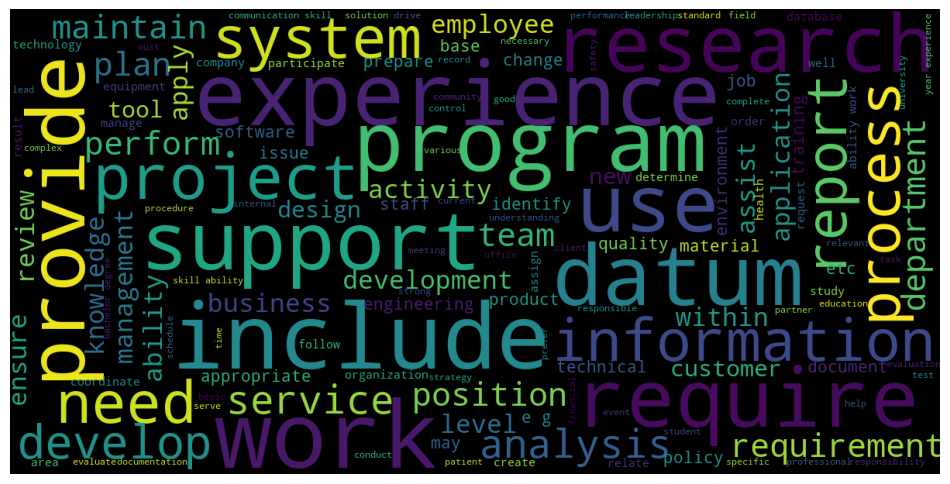

In [503]:
# Generate word clouds for each cluster
for i in range(num_clusters):
    print(f'Cluster: {i}')
    show_wordcloud(' '.join(job_postings['pre_processed'].values[labels == i]))
    print()


In [504]:
# Add cluster labels to the dataset
job_postings['cluster_label_method_1'] = labels

In [505]:
job_postings[job_postings['cluster_label_method_1'] == 0].sample(5)

file_name  \
921   a2f2f0dbf5817d51.html   
635   6d46ebdcfdb34fb4.html   
902   9f43077fb51d74d7.html   
1174  d304c0eeb5beecbb.html   
478   50feb924160cb690.html   

                                               job_desc  \
921   Manager of Data Science - Burbank California -...   
635   Use R to assemble, manipulate, and leverage la...   
902   Developing, maintaining, and enhancing our set...   
1174  Build machine learning systems to understand t...   
478   Work in multi-disciplinary and cross-functiona...   

                                              job_title  \
921          manager of data science burbank california   
635                               data science engineer   
902                                   network developer   
1174                      ecommerce data science intern   
478   sr associate data scientist natural language p...   

                                          pre_processed  \
921   manager datum science burbank burbank year pro...   
635   use r assemble manipulate leverage large datas...   
902   develop maintain enhance set open source inter...   
1174  build machine learning system understand cross...   
478   work multi disciplinary cross functional team ...   

      pre_processed_text_len  pre_processed_word_count  cluster_label_method_1  
921                     4232                       524                       0  
635                     1537                       197                       0  
902                     1411                       171                       0  
1174                    1861                       226                       0  
478                     2638                       319                       0

In [506]:
job_postings[job_postings['cluster_label_method_1'] == 1].sample(5)

file_name  \
864   98fd7c6709a44fec.html   
914   a16b4cadcb1a1470.html   
1355  f4102111ed32f7f9.html   
792   88088691f91338fc.html   
528   5ad1f895aff1a7bd.html   

                                               job_desc  \
864   Develop analytical (predictive, optimization) ...   
914   Strong experience designing quantitative model...   
1355  Build machine learning systems to understand t...   
792   Lead model development, providing methodology,...   
528   Lead a group of data scientists in the develop...   

                                              job_title  \
864                                 data science intern   
914                        data scientist deep learning   
1355                    ecommerce senior data scientist   
792                               senior data scientist   
528   sr lead data scientist peacock direct to consumer   

                                          pre_processed  \
864   develop analytical predictive optimization sol...   
914   strong experience design quantitative modeling...   
1355  build machine learning system understand cross...   
792   lead model development provide methodology str...   
528   lead group datum scientist development analyti...   

      pre_processed_text_len  pre_processed_word_count  cluster_label_method_1  
864                      893                       105                       1  
914                      903                       114                       1  
1355                    1211                       148                       1  
792                     1594                       201                       1  
528                     2471                       308                       1

In [507]:
job_postings[job_postings['cluster_label_method_1'] == 2].sample(5)

file_name  \
1241  de929f0046a05d59.html   
750   81787fb0dcaa3bec.html   
631   6ccd517091a6c107.html   
1245  df1696c67b2bb790.html   
1361  f4d7032f0061044a.html   

                                               job_desc  \
1241  Prepares Market Development Plans by segmentin...   
750   Associate, Data Science and Client Analytics -...   
631   Policy and Planning Specialist - Oakland, CA 9...   
1245  Evaluate process changes and implementation of...   
1361  ACCOUNT CLERK I/II - Benicia, CA This position...   

                                              job_title  \
1241  real estate development manager southern calif...   
750         associate data science and client analytics   
631                      policy and planning specialist   
1245                         quality assurance engineer   
1361                                 account clerk i ii   

                                          pre_processed  \
1241  prepare market development plan segment market...   
750   associate datum science client analytic prince...   
631   policy planning specialist oakland policy plan...   
1245  evaluate process change implementation new pro...   
1361  account clerk ii benicia position open fill fi...   

      pre_processed_text_len  pre_processed_word_count  cluster_label_method_1  
1241                    1894                       238                       2  
750                     1684                       212                       2  
631                     4020                       484                       2  
1245                    2407                       288                       2  
1361                    7079                       891                       2

### Clustering Method 2: Doc2Vec, PCA and K-Means

In [511]:
# Prepare data for Doc2Vec
tagged_data = [TaggedDocument(words=d.split(), tags=[str(i)]) for i, d in enumerate(job_postings['pre_processed'].values)]

In [513]:
# Train the Doc2Vec model
doc2vec_model = Doc2Vec(tagged_data, vector_size=700, window=5, 
                        min_count=5, workers=4)

In [514]:
# Get the vector for each job description
job_desc_vectors = [doc2vec_model.dv[str(i)] for i in range(len(job_postings['pre_processed'].values))]

In [515]:
max_value = 15
components = range(1, max_value+1, 2)

exp_var = []

# Find the optimal number of components for dimensionality reduction.
for comp in components:
    pca = PCA(n_components=comp)
    pca.fit(job_desc_vectors)
    var_exp = pca.explained_variance_ratio_.sum()
    exp_var.append(var_exp)

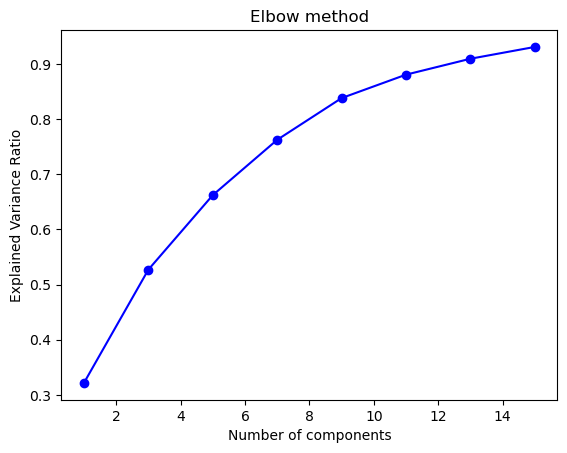

In [516]:
plt.plot(components, exp_var, 'bo-')
plt.xlabel('Number of components')
plt.ylabel('Explained Variance Ratio')
plt.title('Elbow method')
plt.show()

In [517]:
# Perform PCA
pca = PCA(n_components=15)
result = pca.fit_transform(job_desc_vectors)

In [518]:
sil = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(result)
    preds = kmeans.predict(result)
    sil.append(silhouette_score(result, preds, metric = 'cosine'))

C:\Users\subbu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\subbu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\subbu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\subbu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

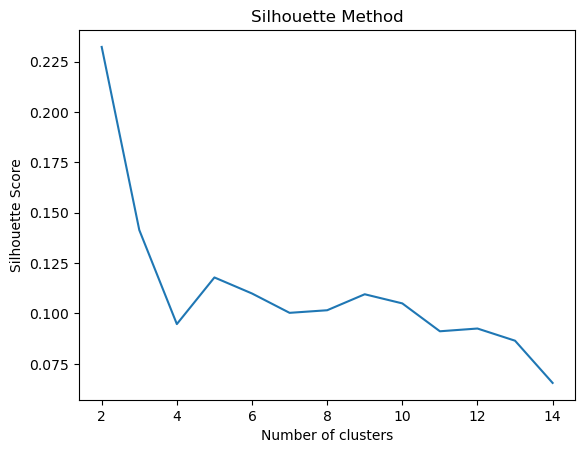

In [519]:
plt.plot(range(2, 15), sil)
plt.title('Silhouette Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [520]:
num_clusters = 2

In [521]:
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(result)
labels = kmeans.predict(result)

C:\Users\subbu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


Cluster: 0


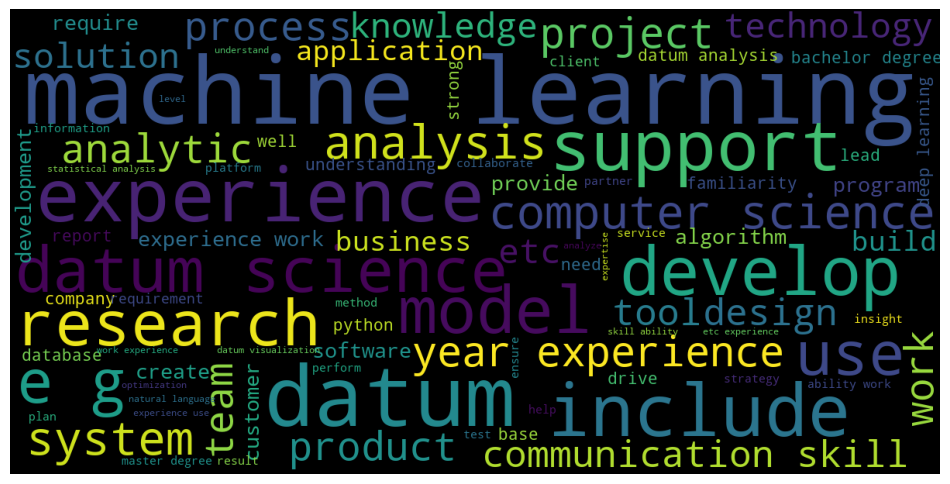


Cluster: 1


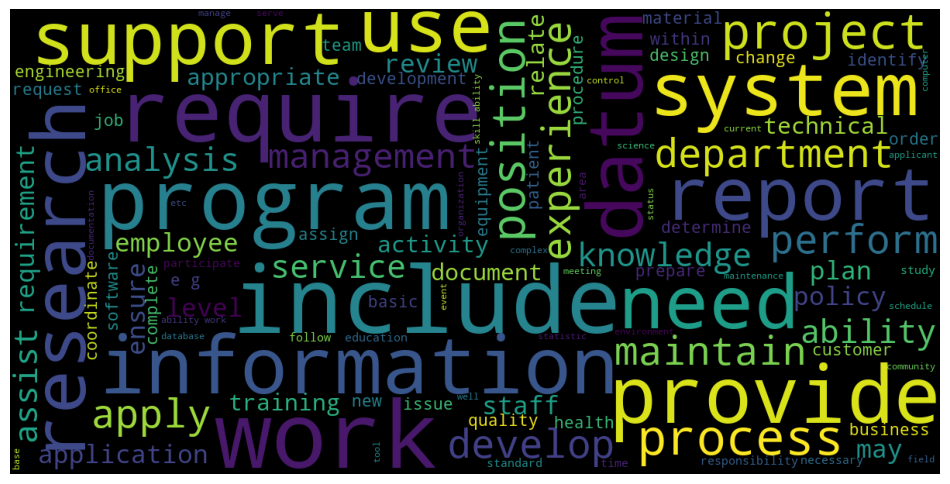

In [522]:
# Generate word clouds for each cluster
for i in range(num_clusters):
    print(f'Cluster: {i}')
    show_wordcloud(' '.join(job_postings['pre_processed'].values[labels == i]))
    print()


In [523]:
# Add cluster labels to the dataset
job_postings['cluster_label_method_2'] = labels

In [524]:
job_postings[job_postings['cluster_label_method_2'] == 0].sample(5)

file_name  \
1144  cc6005a0d4b931dd.html   
733   7f255f64aa64f769.html   
788   8707c2ca919bba90.html   
170   1e561381f5fb4ce7.html   
1381  f8afd87cb9e11776.html   

                                               job_desc  \
1144  Work with diverse, large, and complex datasets...   
733   Understand the fraud and risk processes inhere...   
788   Bootstrapping our company DevOps culture and p...   
170   * What is your level of knowledge and experien...   
1381  Research Scientist in Natural Language Process...   

                                              job_title  \
1144              analyst intern data science solutions   
733                               senior data scientist   
788           member of technical staff devops engineer   
170                                    research analyst   
1381  research scientist in natural language processing   

                                          pre_processed  \
1144  work diverse large complex dataset solve dynam...   
733   understand fraud risk process inherent product...   
788   bootstrappe company devop culture practice col...   
170   level knowledge experience use sql base query ...   
1381  research scientist natural language processing...   

      pre_processed_text_len  pre_processed_word_count  \
1144                     791                        96   
733                     2057                       262   
788                     1050                       126   
170                      447                        58   
1381                    1477                       181   

      cluster_label_method_1  cluster_label_method_2  
1144                       0                       0  
733                        1                       0  
788                        0                       0  
170                        0                       0  
1381                       0                       0

In [525]:
job_postings[job_postings['cluster_label_method_2'] == 1].sample(5)

file_name  \
511   56a6f4598dd4f43f.html   
486   5296567adf37120e.html   
1146  cd242565218ecf56.html   
1372  f760036e4f12e596.html   
573   624c6d38e38e1ef4.html   

                                               job_desc  \
511   You will serve as the System Development Activ...   
486   Social/Behavioral Sciences - San Marcos, CA 92...   
1146  Plans, organizes, coordinates and implements d...   
1372  Clinical Knowledge. Demonstrates an understand...   
573   Technical Research Analyst - Santa Monica, CA ...   

                                              job_title  \
511                                  engineer scientist   
486                          social behavioral sciences   
1146  associate management analyst management analys...   
1372            staff nurse ii telemetry noc benefitted   
573                          technical research analyst   

                                          pre_processed  \
511   serve system development activity sda test lea...   
486   social behavioral sciences san marcos soc intr...   
1146  plan organize coordinate implement day day pro...   
1372  clinical knowledge demonstrate understanding p...   
573   technical research analyst santa monica job ty...   

      pre_processed_text_len  pre_processed_word_count  \
511                    13761                      1700   
486                     3593                       444   
1146                    4998                       603   
1372                    1742                       202   
573                     2374                       296   

      cluster_label_method_1  cluster_label_method_2  
511                        2                       1  
486                        2                       1  
1146                       2                       1  
1372                       2                       1  
573                        0                       1

#### Clustering Method 3: Top2Vec and Clustering

In [581]:
job_descriptions = job_postings['job_desc'].values

In [582]:
# Train a Top2Vec model
model = Top2Vec(documents=job_descriptions,
                speed="learn",
                ngram_vocab=True,
#                min_count=5,
                workers=4)

2023-06-20 19:03:03,728 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2023-06-20 19:03:06,872 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2023-06-20 19:03:55,315 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2023-06-20 19:04:04,270 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-06-20 19:04:04,342 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


In [583]:
# Get the number of detected topics (clusters)
num_topics = model.get_num_topics()
print(f'Number of topics: {num_topics}')

Number of topics: 4


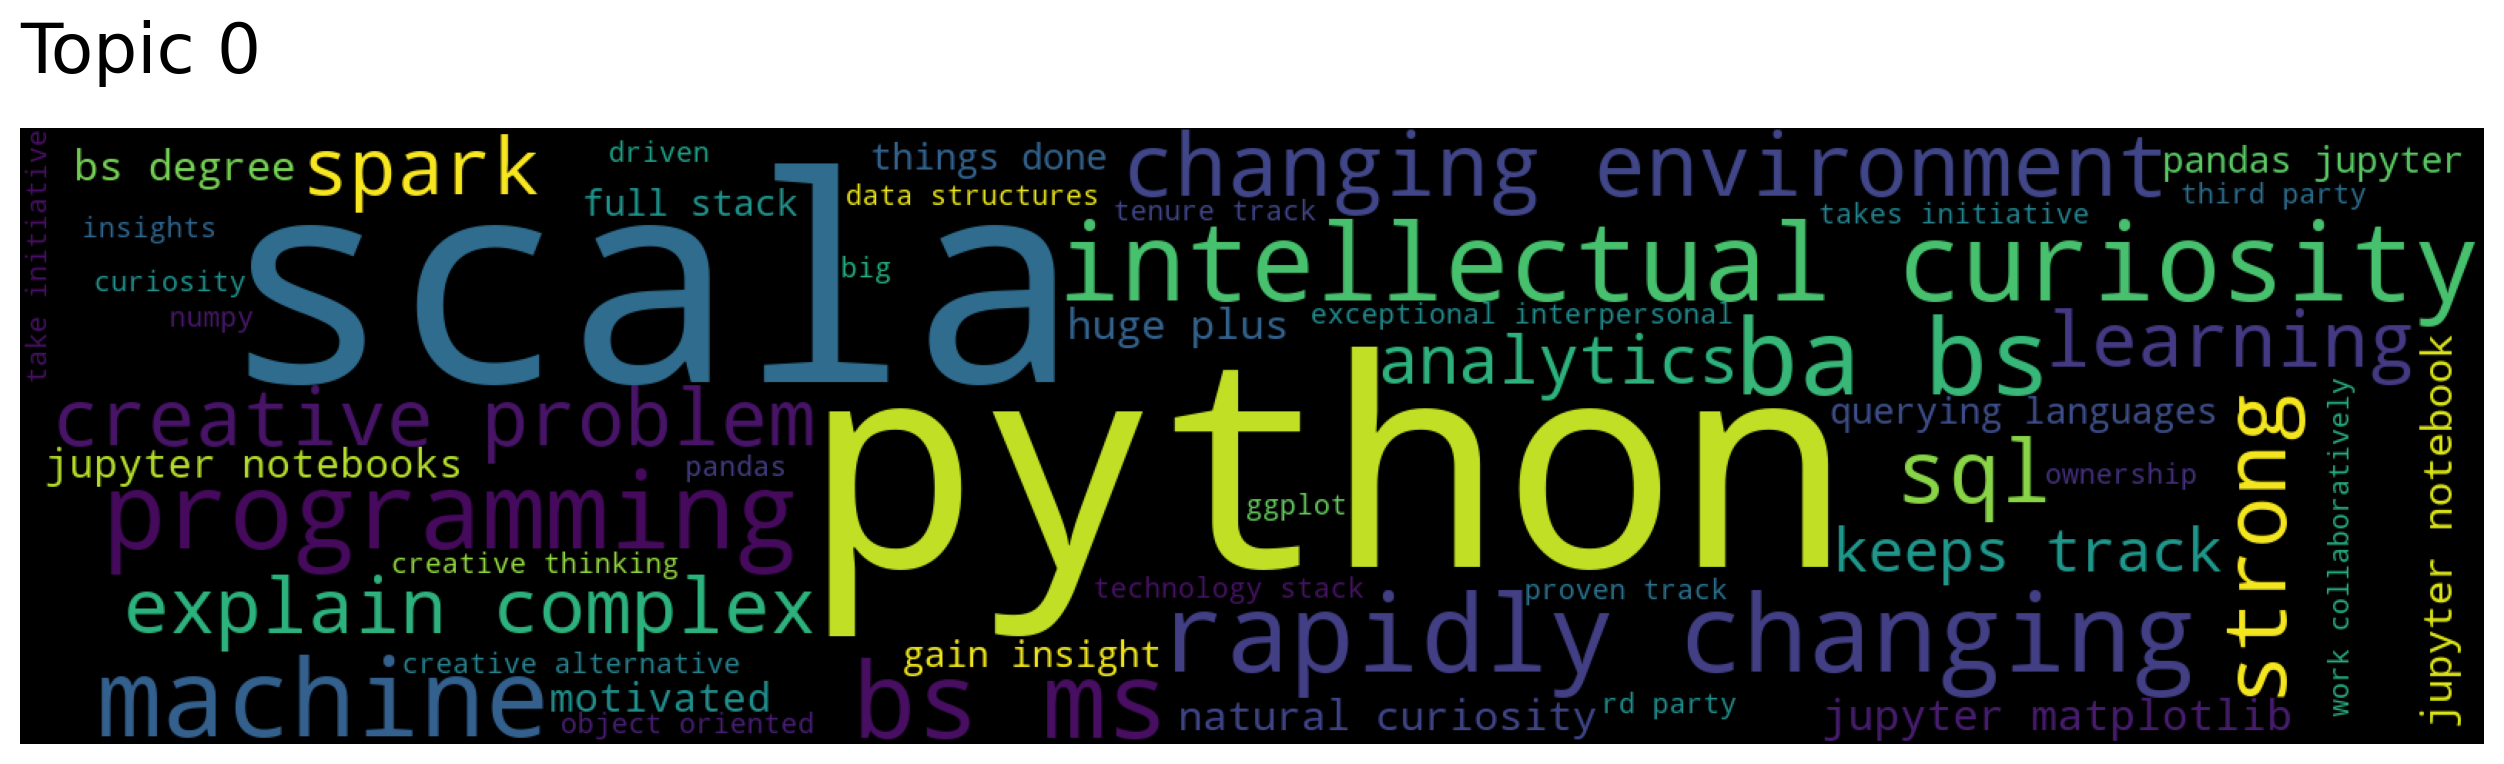

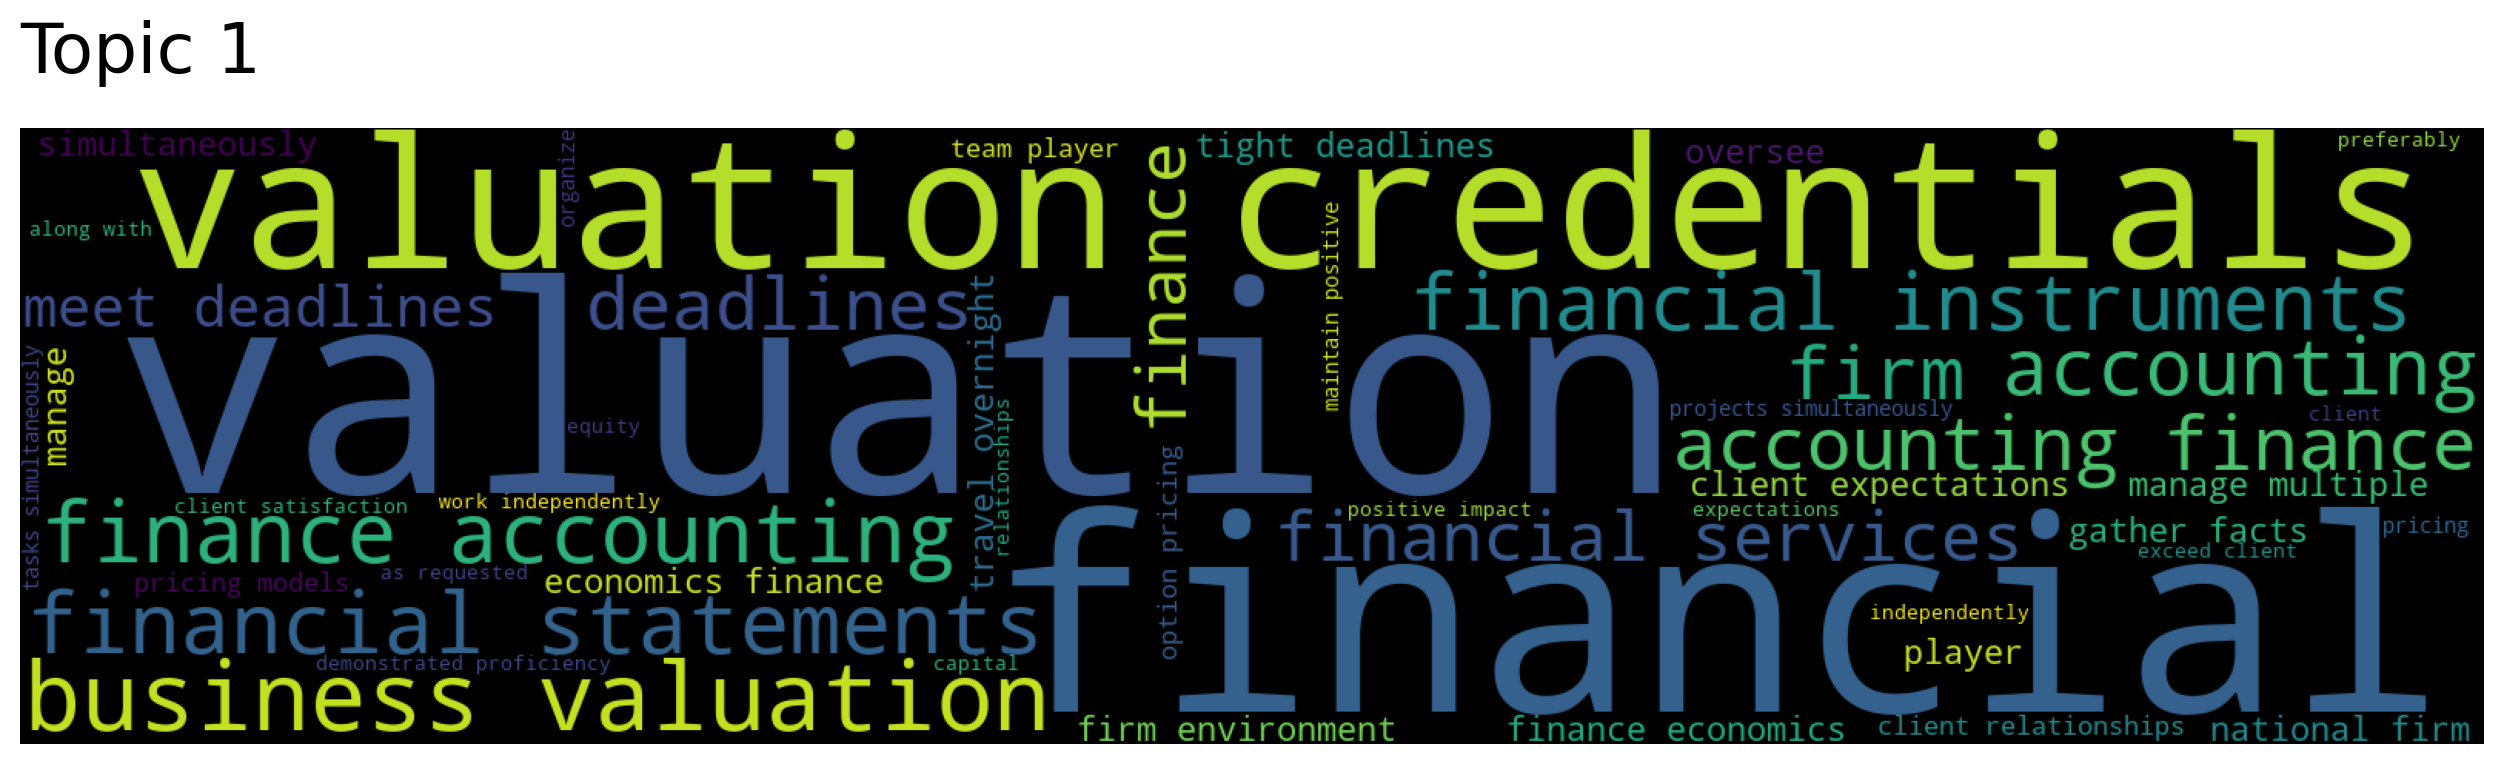

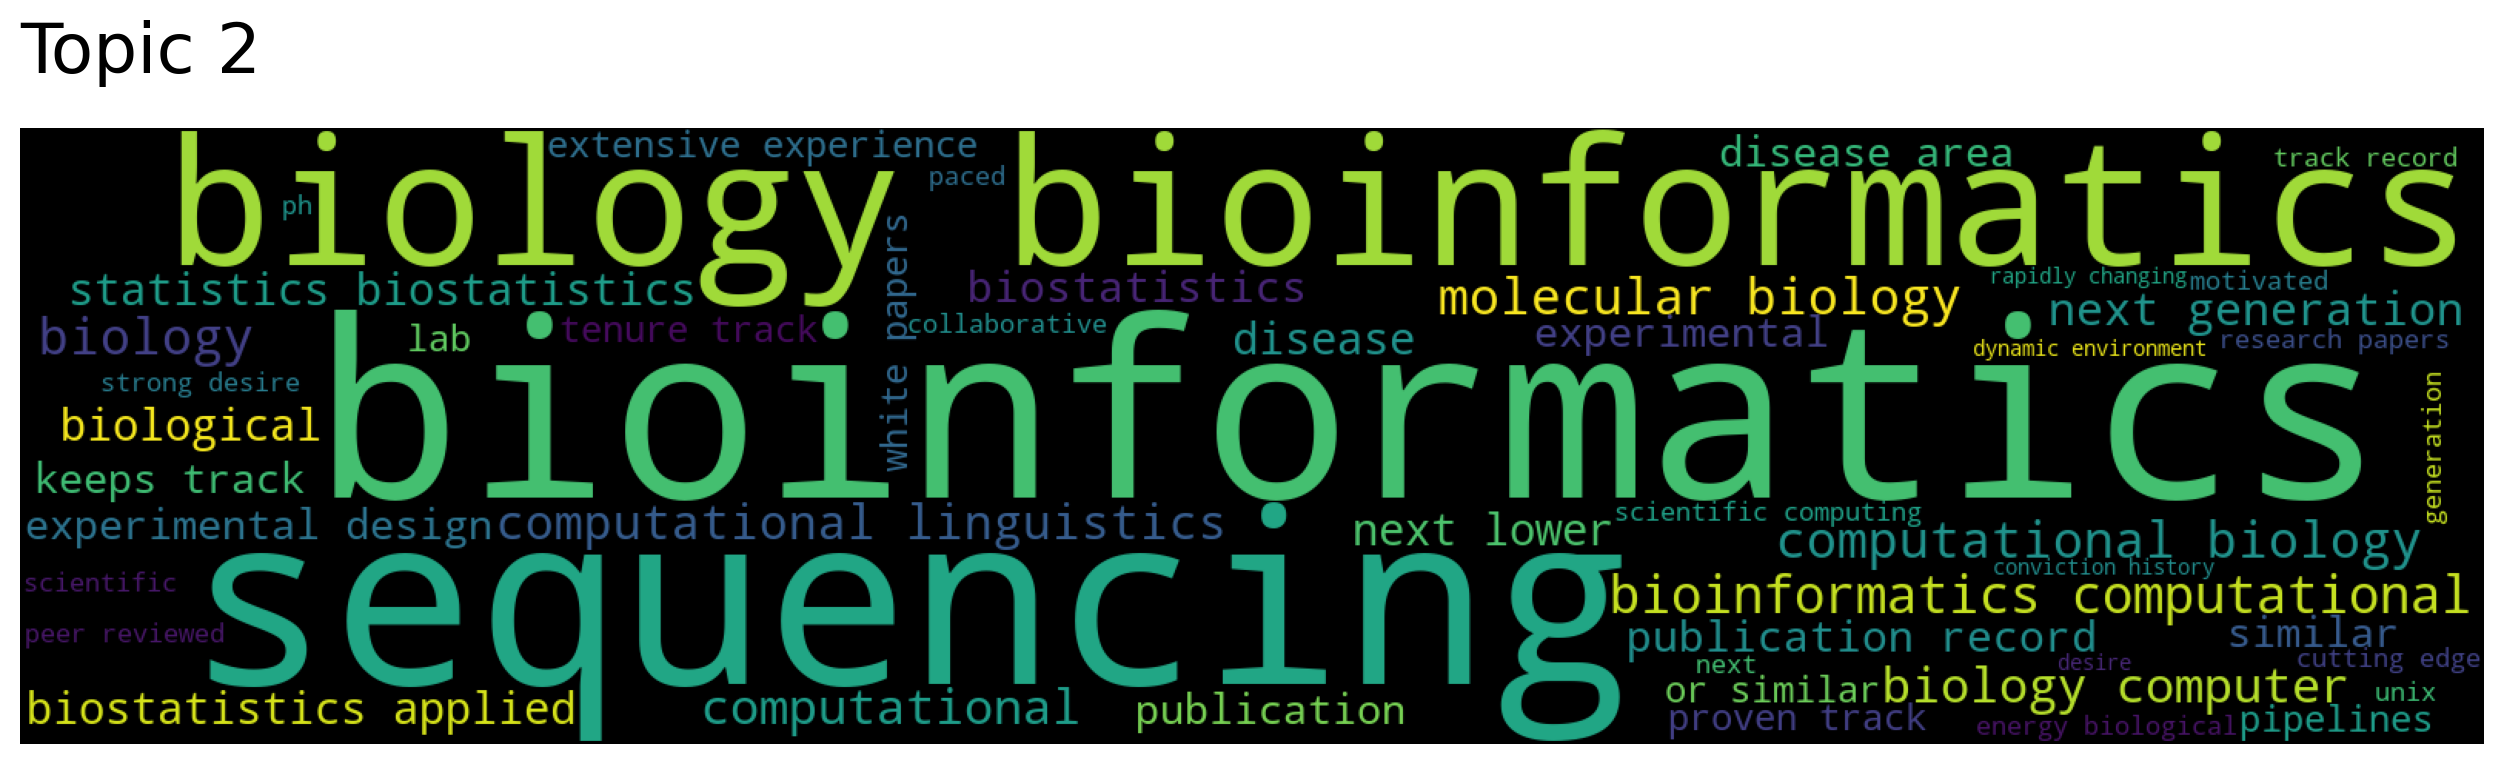

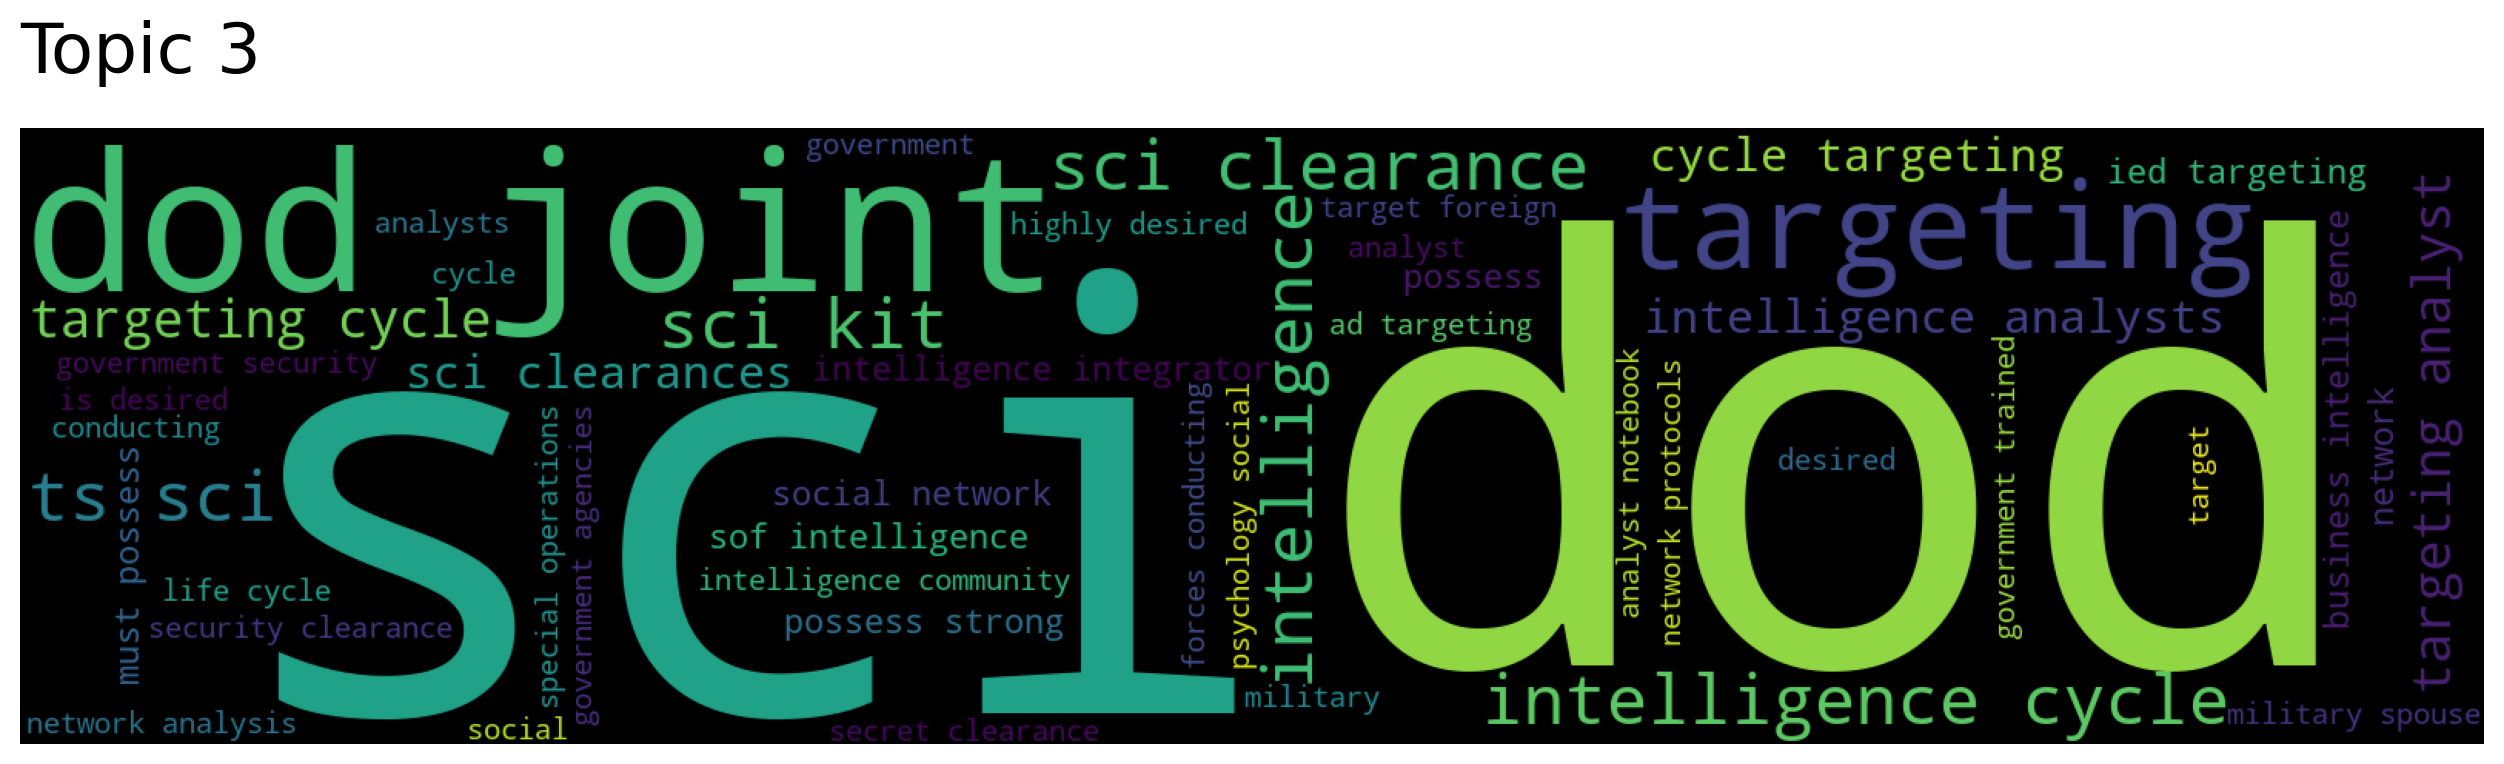

In [584]:
for i in range(num_topics):
    model.generate_topic_wordcloud(i)

In [585]:
# Topic 0 - Core skills relevant to DataScience
# Topic 1 - Job skills related to finance domain
# Topic 2 - Job skills related to medical domain
# Topic 3 - Analyst jobs related to government

In [586]:
topic_words, word_scores, topic_nums = model.get_topics()


In [587]:
topic_words

array([['python', 'scala', 'intellectual curiosity', 'machine',
        'rapidly changing', 'ba bs', 'bs ms', 'programming',
        'changing environment', 'strong', 'sql', 'creative problem',
        'spark', 'explain complex', 'learning', 'analytics',
        'keeps track', 'jupyter matplotlib', 'natural curiosity',
        'huge plus', 'bs degree', 'jupyter notebook',
        'jupyter notebooks', 'motivated', 'querying languages',
        'things done', 'pandas jupyter', 'full stack', 'gain insight',
        'exceptional interpersonal', 'driven', 'curiosity',
        'technology stack', 'big', 'rd party', 'creative thinking',
        'insights', 'third party', 'pandas', 'data structures', 'numpy',
        'object oriented', 'proven track', 'takes initiative',
        'ownership', 'take initiative', 'work collaboratively',
        'tenure track', 'creative alternative', 'ggplot'],
       ['valuation', 'financial', 'valuation credentials',
        'business valuation', 'financial sta

In [590]:
job_postings['cluster_label_method_3'] = 0

In [591]:
topic_sizes, topic_nums = model.get_topic_sizes()

In [593]:
# Then, for each topic, get the documents (job descriptions) that are most similar to it
for topic, size in zip(topic_nums, topic_sizes):
    topic_documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=topic, num_docs=size)
    #print(f'Topic {topic}:')
    #print(document_ids)
    job_postings.loc[document_ids, 'cluster_label_method_3'] = topic

### Checking for the topic assigned by top2vec model for the sample resume

In [614]:
with open('resume.txt') as file:
    document = file.read()

In [615]:
document

'Experience\n\n1. Developed probability simulations using NumPy.\n2. Assessed online ad-clicks for statistical significance using Permutation testing.\n3. Analyzed disease outbreaks using common clustering algorithms.\n\nAdditional Skills\n\n1. Data visualization using Matplotlib.\n2. Statistical analysis using SciPy.\n3. Processing structured tables using Pandas.\n4. Executing K-Means clustering and DBSCAN clustering using Scikit-Learn.\n5. Extracting locations from text using GeonamesCache.\n6. Location analysis and visualization using GeonamesCache and Basemap.\n7. Dimensionality reduction with PCA and SVD, using Scikit-Learn.\n8. NLP analysis and text topic detection using Scikit-Learn.'

In [616]:
preprocessed_doc = preprocess_text(document)
preprocessed_doc

'experience develop probability simulation use numpy assess online ad click statistical significance use permutation testing analyze disease outbreak use common clustering algorithm additional skill datum visualization use matplotlib statistical analysis use scipy process structured table use panda execute k means clustering dbscan clustering use scikit learn extracting location text use geonamescache location analysis visualization use geonamescache basemap dimensionality reduction pca svd use scikit learn nlp analysis text topic detection use scikit learn'

In [617]:
# query topics based on given text input
topic_words, word_scores, topic_scores, topic_nums = model.query_topics(document, num_topics=1)

In [618]:
topic_nums

array([0], dtype=int64)

It is correctly assigning to topic 0 which is related to DS skills

In [650]:
job_postings[job_postings['cluster_label_method_3'] == 0].shape

(1055, 9)

In [651]:
job_postings[job_postings['cluster_label_method_3'] == 1].shape

(129, 9)

In [652]:
job_postings[job_postings['cluster_label_method_3'] == 2].shape

(124, 9)

In [653]:
job_postings[job_postings['cluster_label_method_3'] == 3].shape

(110, 9)